In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from flask import Flask, request, jsonify, render_template
from flask_ngrok import run_with_ngrok
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
df = pd.read_csv("D:/Machine Learning Projects/5. Behavioral Segmentation of Retail Customers using Clustering/df_scaled.csv")

### Elbow Method

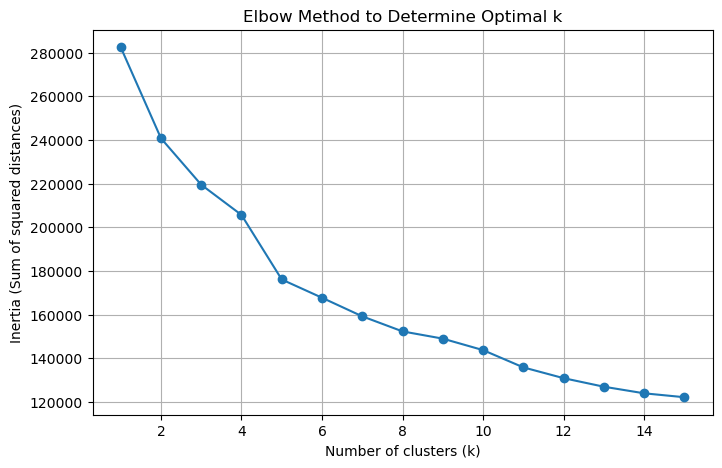

In [4]:
cluster_range = range(1, 16)
inertia = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)  # Use your scaled dataframe
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8,5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method to Determine Optimal k')
plt.grid(True)
plt.show()

## Clustering

#### KMeans

In [19]:
# Try different K values
for k in [3, 4, 5, 6]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df)

    # Take random sample of indices for silhouette
    sample_size = min(20000, len(df))  
    sample_idx = np.random.choice(df.index, sample_size, replace=False)

    sil = silhouette_score(df.loc[sample_idx], labels[sample_idx])
    ch = calinski_harabasz_score(df, labels)
    db = davies_bouldin_score(df, labels)

    results.append((k, sil, ch, db))

# Put results into a DataFrame
results_df = pd.DataFrame(results, columns=["K", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])
print(results_df)

   K  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  3    0.182467       73034.355367        1.771394
1  4    0.157545       66072.231935        1.846929
2  5    0.170039       60678.430214        1.701659
3  6    0.156243       56934.852857        1.715348


#### MiniBatchKMeans

In [17]:
k_values = [3, 4, 5, 6]

results = []

# use only a sample for Silhouette if dataset is huge
sample_size = 20000
if df.shape[0] > sample_size:
    sample_idx = np.random.choice(df.shape[0], sample_size, replace=False)
    df_sample = df.iloc[sample_idx]
else:
    df_sample = df

for k in k_values:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000, n_init=10)
    mbk.fit(df)

    labels = mbk.labels_

    # silhouette on sample to save memory
    sil = silhouette_score(df_sample, mbk.predict(df_sample))
    ch = calinski_harabasz_score(df, labels)
    dbi = davies_bouldin_score(df, labels)

    results.append([k, sil, ch, dbi])

# put into a DataFrame for clean display
results_df = pd.DataFrame(results, columns=["K", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])
print(results_df)

   K  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  3    0.143498       57431.809656        2.287646
1  4    0.161156       65785.038554        1.791045
2  5    0.143116       58325.786731        1.940910
3  6    0.138093       53265.112533        1.897467


#### Birch

In [22]:
results_birch = []

for k in [3, 4, 5, 6]:
    birch = Birch(n_clusters=k, threshold=0.5)
    labels = birch.fit_predict(df)

    # Sample indices consistently for both X and y
    sample_size = min(20000, len(df))
    sample_idx = np.random.choice(df.index, sample_size, replace=False)

    sil = silhouette_score(df.loc[sample_idx], labels[sample_idx])
    ch = calinski_harabasz_score(df, labels)
    db = davies_bouldin_score(df, labels)

    results_birch.append([k, sil, ch, db])

results_birch = pd.DataFrame(results_birch, 
                             columns=["K", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])
print(results_birch)

   K  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  3    0.307057       37433.116799        1.291941
1  4    0.189014       36835.728135        1.621202
2  5    0.193101       28273.485912        1.532243
3  6    0.186790       22843.937342        1.674859


#### PCA

In [25]:
# Step 1: PCA (reduce dimensionality for GMM)
pca = PCA(n_components=None, random_state=42)
df_reduced = pca.fit_transform(df)

results_gmm = []

for k in [3, 4, 5, 6]:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(df_reduced)

    # Sample indices consistently for both X and y
    sample_size = min(20000, len(df_reduced))
    sample_idx = np.random.choice(range(len(df_reduced)), sample_size, replace=False)

    sil = silhouette_score(df_reduced[sample_idx], labels[sample_idx])
    ch = calinski_harabasz_score(df_reduced, labels)
    db = davies_bouldin_score(df_reduced, labels)

    results_gmm.append([k, sil, ch, db])

results_gmm = pd.DataFrame(results_gmm, 
                           columns=["K", "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"])
print(results_gmm)

   K  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  3    0.309728       37404.604577        1.295515
1  4    0.118612       44710.685769        2.068209
2  5    0.141689       39241.021928        2.284787
3  6    0.090571       37015.767716        2.424102


#### DBSCAN

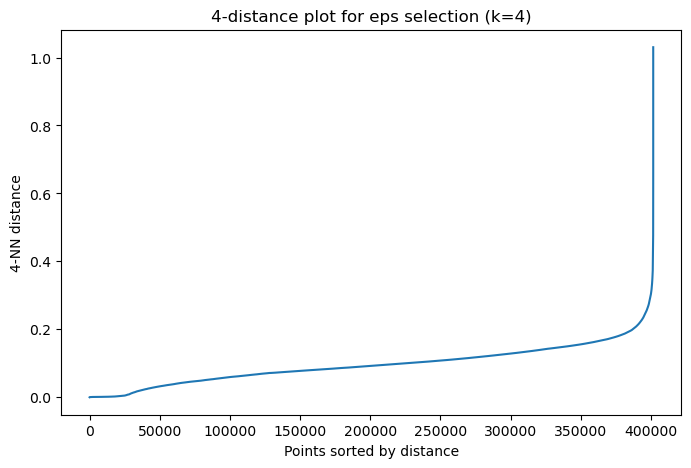

In [29]:
# Step 1: Pick k (usually min_samples from DBSCAN, default = 5)
k = 4

# Step 2: Fit Nearest Neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)

# Step 3: Sort the k-th nearest neighbor distances
distances = np.sort(distances[:, k-1])  # take the k-th distance
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.ylabel(f"{k}-NN distance")
plt.xlabel("Points sorted by distance")
plt.title(f"{k}-distance plot for eps selection (k={k})")
plt.show()

In [33]:
dbscan = DBSCAN(eps=0.2, min_samples=5, n_jobs=-1)
labels = dbscan.fit_predict(df)

# Convert to pandas Series aligned with df
labels_series = pd.Series(labels, index=df.index)

# Exclude noise points (-1)
mask = labels_series != -1

if mask.sum() > 0 and labels_series[mask].nunique() > 1:
    # Sample consistently
    sample = df[mask].sample(min(20000, mask.sum()), random_state=42)
    sample_labels = labels_series.loc[sample.index]

    sil = silhouette_score(sample, sample_labels)
    ch = calinski_harabasz_score(sample, sample_labels)
    db = davies_bouldin_score(sample, sample_labels)

    print(f"Silhouette: {sil}")
    print(f"Calinski-Harabasz: {ch}")
    print(f"Davies-Bouldin: {db}")
else:
    print("DBSCAN found only one cluster or all noise.")

Silhouette: -0.3442580545367786
Calinski-Harabasz: 18.444634160404508
Davies-Bouldin: 1.0834141275857507


### Downlading best Clutering Model

In [3]:
gmm = GaussianMixture(n_components=3, random_state=42)
labels = gmm.fit_predict(df)

In [4]:
joblib.dump(gmm, "D:/Machine Learning Projects/5. Behavioral Segmentation of Retail Customers using Clustering/gmm_model.pkl")

['D:/Machine Learning Projects/5. Behavioral Segmentation of Retail Customers using Clustering/gmm_model.pkl']

In [5]:
df["Cluster"] = labels

In [6]:
df

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceHour,InvoiceWeekday,TransactionType,Cluster
0,0.000000,0.882161,0.954044,0.500037,0.000065,0.926443,0.972222,0,1.0,0.000000,0.142857,0.333333,1,1
1,0.000000,0.719251,0.956098,0.500037,0.000087,0.926443,0.972222,0,1.0,0.000000,0.142857,0.333333,1,1
2,0.000000,0.775183,0.221053,0.500049,0.000071,0.926443,0.972222,0,1.0,0.000000,0.142857,0.333333,1,1
3,0.000000,0.761064,0.465469,0.500037,0.000087,0.926443,0.972222,0,1.0,0.000000,0.142857,0.333333,1,1
4,0.000000,0.760793,0.712709,0.500037,0.000087,0.926443,0.972222,0,1.0,0.000000,0.142857,0.333333,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401559,0.835294,0.399131,0.581001,0.500074,0.000022,0.056219,0.361111,1,1.0,0.266667,0.428571,0.666667,1,2
401560,0.835294,0.474070,0.178434,0.500037,0.000054,0.056219,0.361111,1,1.0,0.266667,0.428571,0.666667,1,2
401561,0.835294,0.566386,0.179974,0.500025,0.000106,0.056219,0.361111,1,1.0,0.266667,0.428571,0.666667,1,2
401562,0.835294,0.566658,0.179718,0.500025,0.000106,0.056219,0.361111,1,1.0,0.266667,0.428571,0.666667,1,2


D:\ANACONDA\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


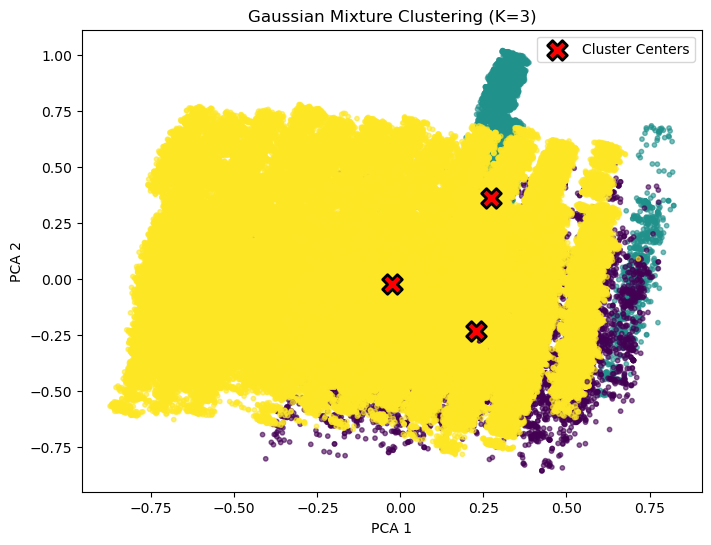

In [7]:
X = df.drop(columns=["Cluster"], errors="ignore")
pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(X)

# Transform GMM means to PCA space
means_pca = pca.transform(gmm.means_)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0], df_pca[:,1], c=labels, cmap="viridis", s=10, alpha=0.6)
plt.scatter(means_pca[:,0], means_pca[:,1], c="red", marker="X", s=200,
            edgecolor="k", linewidth=2, label="Cluster Centers")
plt.title("Gaussian Mixture Clustering (K=3)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()

In [8]:
df["Cluster"].value_counts()


Cluster
2    367001
1     26351
0      8212
Name: count, dtype: int64

In [11]:
cluster_summary = df.groupby("Cluster").agg({
    'Quantity': ['mean', 'sum', 'median'],
    'UnitPrice': ['mean', 'median'],
    'CustomerID': pd.Series.nunique,  # number of unique customers in cluster
    'TransactionType': pd.Series.nunique,  # how many different transaction types
    'Country': pd.Series.nunique  # number of countries represented
})

cluster_summary.columns = ['Quantity_mean', 'Quantity_sum', 'Quantity_median',
                           'UnitPrice_mean', 'UnitPrice_median',
                           'UniqueCustomers', 'TransactionTypes', 'Countries']

print(cluster_summary)


         Quantity_mean   Quantity_sum  Quantity_median  UnitPrice_mean  \
Cluster                                                                  
0             0.499923    4105.370850         0.499988        0.000675   
1             0.500069   13177.322100         0.500025        0.000083   
2             0.500079  183529.425989         0.500037        0.000076   

         UnitPrice_median  UniqueCustomers  TransactionTypes  Countries  
Cluster                                                                  
0                0.000076             1493                 2         27  
1                0.000054              948                 2         23  
2                0.000047             4218                 2         36  


In [12]:
df["CustomerType"] = df["Cluster"].map({
    0: "Premium",
    1: "Occasional",
    2: "Regular"
})

In [13]:
df

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceHour,InvoiceWeekday,TransactionType,Cluster,CustomerType
0,0.000000,0.882161,0.954044,0.500037,0.000065,0.926443,0.972222,0,1.0,0.000000,0.142857,0.333333,1,1,Occasional
1,0.000000,0.719251,0.956098,0.500037,0.000087,0.926443,0.972222,0,1.0,0.000000,0.142857,0.333333,1,1,Occasional
2,0.000000,0.775183,0.221053,0.500049,0.000071,0.926443,0.972222,0,1.0,0.000000,0.142857,0.333333,1,1,Occasional
3,0.000000,0.761064,0.465469,0.500037,0.000087,0.926443,0.972222,0,1.0,0.000000,0.142857,0.333333,1,1,Occasional
4,0.000000,0.760793,0.712709,0.500037,0.000087,0.926443,0.972222,0,1.0,0.000000,0.142857,0.333333,1,1,Occasional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401559,0.835294,0.399131,0.581001,0.500074,0.000022,0.056219,0.361111,1,1.0,0.266667,0.428571,0.666667,1,2,Regular
401560,0.835294,0.474070,0.178434,0.500037,0.000054,0.056219,0.361111,1,1.0,0.266667,0.428571,0.666667,1,2,Regular
401561,0.835294,0.566386,0.179974,0.500025,0.000106,0.056219,0.361111,1,1.0,0.266667,0.428571,0.666667,1,2,Regular
401562,0.835294,0.566658,0.179718,0.500025,0.000106,0.056219,0.361111,1,1.0,0.266667,0.428571,0.666667,1,2,Regular


In [14]:
df.to_csv("D:/Machine Learning Projects/5. Behavioral Segmentation of Retail Customers using Clustering/df_clustered.csv", index = False)

### Deployment

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify, render_template
from pyngrok import ngrok

# ==============================
# Flask Initialization (with custom template path)
# ==============================
TEMPLATE_DIR = r"D:/Machine Learning Projects/5. Behavioral Segmentation of Retail Customers using Clustering/Templates"
app = Flask(__name__, template_folder=TEMPLATE_DIR)
# ==============================
# Ngrok Setup (using your token)
# ==============================
NGROK_AUTH_TOKEN = "31p88w2mFBhEjpQg9XfjhjOJc6u_7LF9KMq6ap49d8A15LWj2"  # replace with your token
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open a ngrok tunnel to the Flask server
public_url = ngrok.connect(5000)
print(" * Ngrok Tunnel URL:", public_url.public_url)

# ==============================
# Load Models and Encoders
# ==============================
base_path = r"D:/Machine Learning Projects/5. Behavioral Segmentation of Retail Customers using Clustering"

# Load encoders
cat_cols = ['InvoiceNo', 'StockCode', 'Description', 'Country', 'TransactionType']
encoders = {col: joblib.load(os.path.join(base_path, f"le_{col}.pkl")) for col in cat_cols}

# Load scaler and GMM model
scaler = joblib.load(os.path.join(base_path, "scaler.pkl"))
gmm = joblib.load(os.path.join(base_path, "gmm_model.pkl"))

# Cluster to CustomerType mapping
cluster_map = {
    0: "Premium",
    1: "Occasional",
    2: "Regular"
}

# ==============================
# Routes
# ==============================
@app.route('/')
def home():
    return render_template("index.html")

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.get_json()  # Expect JSON input from frontend
        if not data:
            return jsonify({"error": "No input data received"}), 400

        # Convert input into DataFrame
        df = pd.DataFrame([data])

        # Apply label encoders
        for col in cat_cols:
            if col in df.columns:
                df[col] = encoders[col].transform(df[col])

        # Scale features
        X_scaled = scaler.transform(df)

        # Predict cluster + probabilities
        cluster = int(gmm.predict(X_scaled)[0])
        probs = gmm.predict_proba(X_scaled)[0]

        # Format probabilities dictionary
        prob_dict = {cluster_map[i]: float(probs[i]) for i in range(len(probs))}

        response = {
            "Cluster": cluster,
            "CustomerType": cluster_map[cluster],
            "Probabilities": prob_dict
        }
        return jsonify(response)

    except Exception as e:
        return jsonify({"error": str(e)}), 500

# ==============================
# Run Flask App
# ==============================
if __name__ == '__main__':
    app.run(port=5000, debug=False, use_reloader=False)


t=2025-09-07T00:14:26+0500 lvl=warn msg="can't bind default web address, trying alternatives" obj=web addr=127.0.0.1:4040


 * Ngrok Tunnel URL: https://47e61ecd2a77.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [07/Sep/2025 00:14:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Sep/2025 00:14:35] "GET /favicon.ico HTTP/1.1" 404 -
D:\ANACONDA\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
D:\ANACONDA\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
127.0.0.1 - - [07/Sep/2025 00:16:19] "POST /predict HTTP/1.1" 200 -
